# LMI clustering for Ca2+/CaM-dependent protein kinase type II

In [1]:
import sys
sys.path.extend(["../code/src"])

from pathlib import Path
import pandas as pd
import numpy as np
import hdbscan
from Bio.PDB import PDBParser
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from utils.structure import extract_sequence_from_chain
from utils.alignment import map_seq_to_alignment, is_increasing_monotonic
from utils.commands import call_muscle
from utils.fasta import write_fasta, parse_fasta
from utils.mappings import LEGAL_AAS_THREE, THREE_TO_ONE
from predict_status.helper import map_seqs_to_alignment

out_path = Path("lmi_O62305_284")
out_path.mkdir(exist_ok=True)

def clustering(X, metric="precomputed"):
    """
    """
    clusterer = hdbscan.HDBSCAN(metric=metric)
    clusterer.fit(1-X)
    labels = clusterer.labels_

    return clusterer, labels

def find_gap_positions(aln):
    """
    Find columns in the alignment which contain at least one gap
    """
    gap_positions = set()
    for aln_seq in aln.values():
        for idx, res in enumerate(aln_seq):
            if res == '-':
                gap_positions.add(idx)
    gap_positions = sorted(list(gap_positions))
    return gap_positions

# Map clusters to sequences
def map_aln_seq_to_lmi_idxs(aln_seq, gap_positions):
    """
    Map positions in the alignment to rows/columns in the LMI matrix
    Basically, it just skips positions corresponding to gaps
    """
    i = 0
    aln_seq_to_lmi_idx = {}
    for idx, res in enumerate(aln_seq):
        if idx in gap_positions:
            continue
        else:
            aln_seq_to_lmi_idx[idx] = i
            i += 1
    return aln_seq_to_lmi_idx

# Map sequences to PDB indexes
def map_seq_to_pdb_idxs(orig_seq, chain, aa_mapping=THREE_TO_ONE):
    seq_to_pdb = {}
    chain = list(chain) # Avoid indexing problems with HETATMs
    for i, res_i in enumerate(orig_seq):
        for j, res_j in enumerate(chain):
            pdb_idx = res_j._id[1]
            try:
                res_j_mapped = aa_mapping[res_j.resname]
            except KeyError:
                continue
        
            if res_i == res_j_mapped and pdb_idx not in seq_to_pdb.values():
                #print("yay!")
                seq_to_pdb[i] = pdb_idx
                break
    
    # Sanity checks
    vals = seq_to_pdb.values()

    # Check that the list of values increases monotonically
    assert is_increasing_monotonic(list(vals))
    # Check that there are no duplicates in the values
    assert sorted(list(set(vals))) == list(vals)
    return seq_to_pdb


def map_pdb_seq_to_cluster(seq_map, seq_to_pdb, cluster_labels, aln_seq_to_lmi_idx, 
                           gap_positions):
    """
    Map positions in the PDB structure to cluster labels
    """
    pdb_seq_idx_to_cluster = {}
    for orig_idx, aln_idx in seq_map.items():
        if aln_idx not in gap_positions:
            pdb_seq_idx = seq_to_pdb[orig_idx]
            lmi_idx = aln_seq_to_lmi_idx[aln_idx]
            cluster = cluster_labels[lmi_idx]
            pdb_seq_idx_to_cluster[pdb_seq_idx] = cluster
    
    return pdb_seq_idx_to_cluster

def make_pymol_selection_string(residues, chain):
  """
  Create a ready-made string that can be used to select residues in PyMol

  Arguments
  ---------
  residues: np.array of integers, residue indexes to be selected
  chain: str, PDB chain identifier

  Returns
  -------
  selection_string: str
  """
  if len(residues) > 0:
    for idx, residue in np.ndenumerate(residues):
      #print(idx, residue)
      if idx[0] == 0:
        cumulative_string = f"resi {residue}"
      else:
        cumulative_string = "".join([cumulative_string, " or", f" resi {residue}"])

    selection_string = f"select ({cumulative_string}) and chain {chain}"
    print(selection_string)
  else:
    warn("No residues, returning empty string",RuntimeWarning)
    selection_string = ""


In [2]:
chains_path = Path("../data/processed/pdb_pairs/chains_by_protein/")
annot_path = Path("../data/processed/pdb_pairs/chains_by_protein/annotation_per_psite/")
nma_results_path = Path("../results/new_nma_analysis_per_psite")
psite = "O62305_284"
uniprot_id, _ = psite.split("_")

In [3]:
annot_df = pd.read_csv(annot_path / f"{psite}.csv")
pdb_to_status = {}
for idx, row in annot_df.iterrows():
    pdb_id = row["Full ID"]
    status = row["Status"]
    pdb_to_status[pdb_id] = status


In [4]:
lmi_diffs = pd.read_csv("../results/new_nma_per_psite_processed/O62305_284/lmi_diffs.csv",index_col=0)

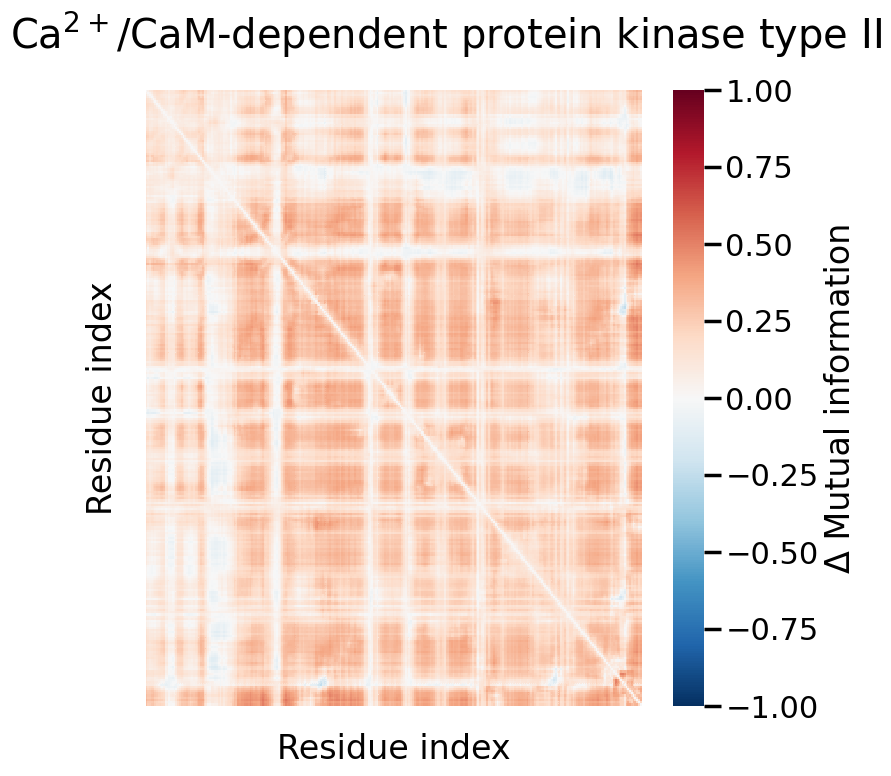

In [8]:
sns.set_context('poster')
plt.figure(figsize=(8,8))

ax = sns.heatmap(lmi_diffs,cmap='RdBu_r',vmin=-1,vmax=1, cbar_kws={'label': 'Δ Mutual information'})
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(left=False, bottom=False)

plt.xlabel('Residue index')
plt.ylabel('Residue index')
plt.suptitle(r"Ca$^{2+}$/CaM-dependent protein kinase type II")
plt.savefig(out_path / "lmi_diffs.pdf",dpi=120,bbox_inches='tight')

In [4]:
# Load structures
pdb_files = list((chains_path / uniprot_id).glob("*.pdb"))

p_chains = {}
np_chains = {}
parser = PDBParser(QUIET=True)
for file in pdb_files:
    pdb_id = file.stem
    chain_id = pdb_id.split("_")[1]
    status = pdb_to_status[pdb_id]
    structure = parser.get_structure(pdb_id, file)
    chain = structure[0][chain_id]
    
    if status == "Phosphorylated":
        p_chains[pdb_id] = chain
    elif status == "Non-phosphorylated":
        np_chains[pdb_id] = chain
    else:
        raise ValueError(f'Invalid status {status} for {pdb_id}')


In [5]:
orig_seqs = {}
for pdb_id, chain in p_chains.items():
    seq = extract_sequence_from_chain(chain)
    orig_seqs[pdb_id] = seq
for pdb_id, chain in np_chains.items():
    seq = extract_sequence_from_chain(chain)
    orig_seqs[pdb_id] = seq

orig_seqs_f = out_path / "orig_seqs.fasta"
aln_seqs_f = out_path / "aln_seqs.fasta"
write_fasta(orig_seqs, str(orig_seqs_f))
call_muscle(str(orig_seqs_f),str(aln_seqs_f))
with open(aln_seqs_f) as f:
    aln = parse_fasta(f)


MUSCLE v3.8.1551 by Robert C. Edgar

http://www.drive5.com/muscle
This software is donated to the public domain.
Please cite: Edgar, R.C. Nucleic Acids Res 32(5), 1792-97.

orig_seqs 3 seqs, lengths min 284, max 309, avg 300
00:00:00    16 MB(-1%)  Iter   1  100.00%  K-mer dist pass 1
00:00:00    16 MB(-1%)  Iter   1  100.00%  K-mer dist pass 2
00:00:00    18 MB(-1%)  Iter   1  100.00%  Align node       
00:00:00    18 MB(-1%)  Iter   1  100.00%  Root alignment
00:00:00    18 MB(-1%)  Iter   2  100.00%  Refine tree   
00:00:00    18 MB(-1%)  Iter   2  100.00%  Root alignment
00:00:00    18 MB(-1%)  Iter   2  100.00%  Root alignment
00:00:00    18 MB(-1%)  Iter   3  100.00%  Refine biparts
00:00:00    18 MB(-1%)  Iter   4  100.00%  Refine biparts
00:00:00    18 MB(-1%)  Iter   5  100.00%  Refine biparts
00:00:00    18 MB(-1%)  Iter   6  100.00%  Refine biparts
00:00:00    18 MB(-1%)  Iter   7  100.00%  Refine biparts
00:00:00    18 MB(-1%)  Iter   8  100.00%  Refine biparts
00:00:00   

In [7]:
# Gap positions are excluded from the NMA output
gap_positions = find_gap_positions(aln)
print(f'Gap positions: {gap_positions}')
# Map unaligned sequences to alignment positions
seq_maps = map_seqs_to_alignment(aln)

NameError: name 'aln' is not defined

In [8]:
lmi_results = list((nma_results_path / psite).glob("*.csv"))
lmi_results = [x for x in lmi_results if x.stem.startswith("lmi_")]

In [9]:
p_lmis = {}
np_lmis = {}

for f in lmi_results:
    lmi_df = pd.read_csv(f,index_col=0)
    _, pdb_id, chain_id, _ = f.parts[-1].split("_")
    full_id = "_".join([pdb_id, chain_id])
    if pdb_to_status[full_id] == "Phosphorylated":
        print(full_id, 'phospho')
        p_lmis[full_id] = lmi_df
    elif pdb_to_status[full_id] == "Non-phosphorylated":
        print(full_id, 'nonphospho')
        np_lmis[full_id] = lmi_df
    else:
        print(f'Invalid status for {full_id}')

2bdw_A nonphospho
2bdw_B nonphospho
3kk8_A phospho


In [9]:
pdb_to_cluster_labels = {}
for pdb_id, lmi_df in p_lmis.items():
    _, cluster_labels = clustering(lmi_df)
    pdb_to_cluster_labels[pdb_id] = cluster_labels
for pdb_id, lmi_df in np_lmis.items():
    _, cluster_labels = clustering(lmi_df)
    pdb_to_cluster_labels[pdb_id] = cluster_labels
    


In [10]:
max_cluster_number = max([len(set(x)) for x in list(pdb_to_cluster_labels.values())])
cluster_to_color = {}
palette = sns.color_palette("tab10", max_cluster_number)
for idx, cluster in enumerate(list(range(-1,max_cluster_number-1))):
    cluster_to_color[cluster] = palette[idx]

pdb_to_cluster_colors = {}
for k, cluster_labels in pdb_to_cluster_labels.items():
    pdb_colors = [cluster_to_color[cluster] for cluster in cluster_labels]
    pdb_to_cluster_colors[k] = pdb_colors

In [11]:
seq_to_lmi_idx_map = {}
for k, seq in aln.items():
    seq_to_lmi_idx = map_aln_seq_to_lmi_idxs(seq, gap_positions)
    seq_to_lmi_idx_map[k] = seq_to_lmi_idx

In [12]:
seq_to_pdb_idxs = {}
chains = {**p_chains,**np_chains}
for k, seq in orig_seqs.items():
    chain = chains[k]
    seq_to_pdb_idxs[k] = map_seq_to_pdb_idxs(seq, chain)


In [13]:
#seq_to_pdb_idxs["2jv3_A"]
#seq_to_pdb_idxs["2kmd_A"]
#seq_to_pdb_idxs["2"]

In [14]:
pdb_idxs_to_clusters = {}
for k in aln.keys():
    pdb_clusters = map_pdb_seq_to_cluster(seq_maps[k], seq_to_pdb_idxs[k], pdb_to_cluster_labels[k],
                                          seq_to_lmi_idx_map[k], gap_positions)
    pdb_idxs_to_clusters[k] = pdb_clusters

In [15]:
cluster_to_residues = defaultdict(lambda: defaultdict(list))
for pdb_id, idxs_to_clusters in pdb_idxs_to_clusters.items():
    #print(k,v)
    cluster_set = set(idxs_to_clusters.values())
    for res, cluster in idxs_to_clusters.items():
        #print(k,item)
        cluster_to_residues[pdb_id][cluster].append(res)

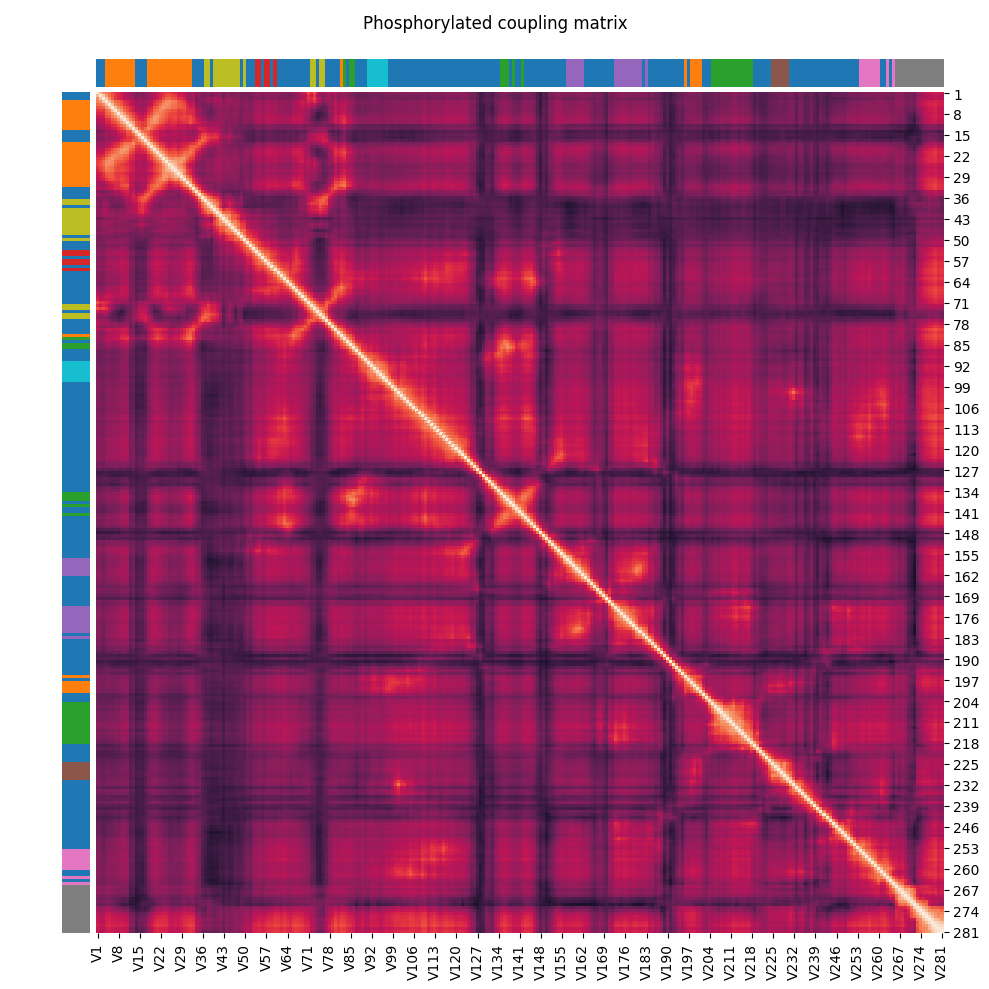

In [25]:
sns.clustermap(p_lmis["3kk8_A"],vmin=0,vmax=1,row_colors=pdb_to_cluster_colors["3kk8_A"], 
               col_colors=pdb_to_cluster_colors["3kk8_A"],
               row_cluster=False, col_cluster=False, dendrogram_ratio=0.05, 
               cbar_pos=None)
plt.suptitle("Phosphorylated coupling matrix")
plt.savefig(out_path / "3kk8_A_lmi.png",dpi=120, bbox_inches='tight')

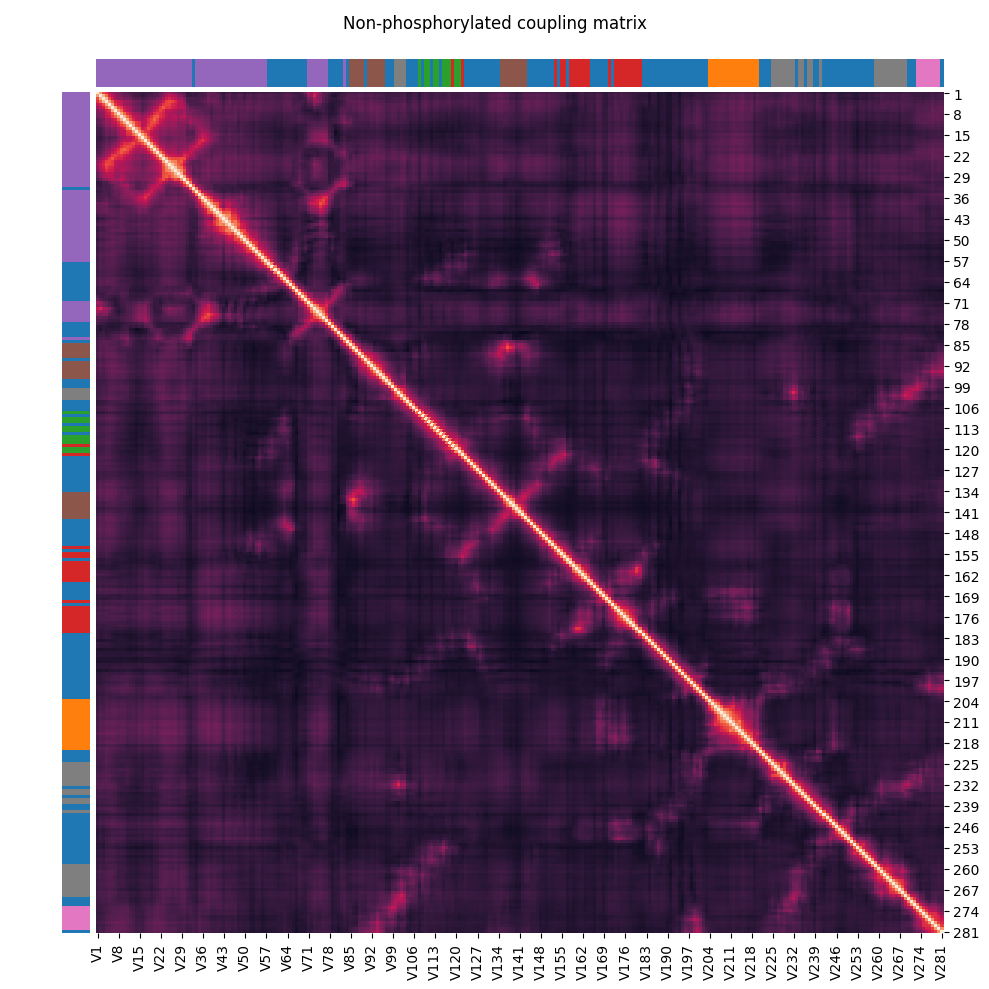

In [26]:
sns.clustermap(np_lmis["2bdw_B"],vmin=0,vmax=1,row_colors=pdb_to_cluster_colors["2bdw_B"], 
               col_colors=pdb_to_cluster_colors["2bdw_B"],
               row_cluster=False, col_cluster=False, dendrogram_ratio=0.05, 
               cbar_pos=None)
plt.suptitle("Non-phosphorylated coupling matrix")
plt.savefig(out_path / "2bdw_B_lmi.png",dpi=120, bbox_inches='tight')

In [22]:
for cluster in cluster_to_residues["3kk8_A"]:
    if len(cluster_to_residues["3kk8_A"][cluster]) > 7:
        print(cluster)
        make_pymol_selection_string(cluster_to_residues["3kk8_A"][cluster],"3kk8_A")

-1
select (resi 9 or resi 10 or resi 11 or resi 22 or resi 23 or resi 24 or resi 25 or resi 41 or resi 42 or resi 43 or resi 44 or resi 47 or resi 57 or resi 59 or resi 60 or resi 61 or resi 64 or resi 67 or resi 69 or resi 70 or resi 71 or resi 72 or resi 73 or resi 74 or resi 75 or resi 76 or resi 77 or resi 78 or resi 79 or resi 82 or resi 85 or resi 86 or resi 87 or resi 88 or resi 89 or resi 92 or resi 95 or resi 96 or resi 97 or resi 98 or resi 106 or resi 107 or resi 108 or resi 123 or resi 129 or resi 130 or resi 131 or resi 132 or resi 133 or resi 134 or resi 135 or resi 136 or resi 137 or resi 138 or resi 139 or resi 140 or resi 141 or resi 142 or resi 146 or resi 148 or resi 149 or resi 151 or resi 152 or resi 153 or resi 154 or resi 155 or resi 156 or resi 157 or resi 158 or resi 159 or resi 160 or resi 161 or resi 162 or resi 163 or resi 164 or resi 171 or resi 172 or resi 173 or resi 174 or resi 175 or resi 176 or resi 177 or resi 178 or resi 179 or resi 180 or resi 190 o

In [24]:
for cluster in cluster_to_residues["2bdw_B"]:
    if len(cluster_to_residues["2bdw_B"][cluster]) > 7:
        print(cluster)
        make_pymol_selection_string(cluster_to_residues["2bdw_B"][cluster],"2bdw_B")

3
select (resi 9 or resi 10 or resi 11 or resi 12 or resi 13 or resi 14 or resi 15 or resi 16 or resi 17 or resi 18 or resi 19 or resi 20 or resi 21 or resi 22 or resi 23 or resi 24 or resi 25 or resi 26 or resi 27 or resi 28 or resi 29 or resi 30 or resi 31 or resi 32 or resi 33 or resi 34 or resi 35 or resi 36 or resi 37 or resi 38 or resi 39 or resi 40 or resi 42 or resi 43 or resi 44 or resi 45 or resi 46 or resi 47 or resi 48 or resi 49 or resi 50 or resi 51 or resi 52 or resi 53 or resi 54 or resi 55 or resi 56 or resi 57 or resi 58 or resi 59 or resi 60 or resi 61 or resi 62 or resi 63 or resi 64 or resi 65 or resi 79 or resi 80 or resi 81 or resi 82 or resi 83 or resi 84 or resi 85 or resi 91) and chain 2bdw_B
-1
select (resi 41 or resi 66 or resi 67 or resi 68 or resi 69 or resi 70 or resi 71 or resi 72 or resi 73 or resi 74 or resi 75 or resi 76 or resi 77 or resi 78 or resi 86 or resi 87 or resi 88 or resi 89 or resi 90 or resi 92 or resi 98 or resi 105 or resi 106 or resi 1

In [146]:
cluster_to_residues

defaultdict(<function __main__.<lambda>()>,
            {'2kmd_A': defaultdict(list,
                         {-1: [29,
                           30,
                           31,
                           43,
                           46,
                           51,
                           53,
                           54,
                           55,
                           56,
                           64,
                           65,
                           66,
                           67,
                           68,
                           69,
                           70,
                           71,
                           72,
                           75,
                           76,
                           77,
                           78,
                           79,
                           80,
                           81,
                           82,
                           83,
                           84,
            

Text(0.5, 0.98, 'Non-phosphorylated LMI')

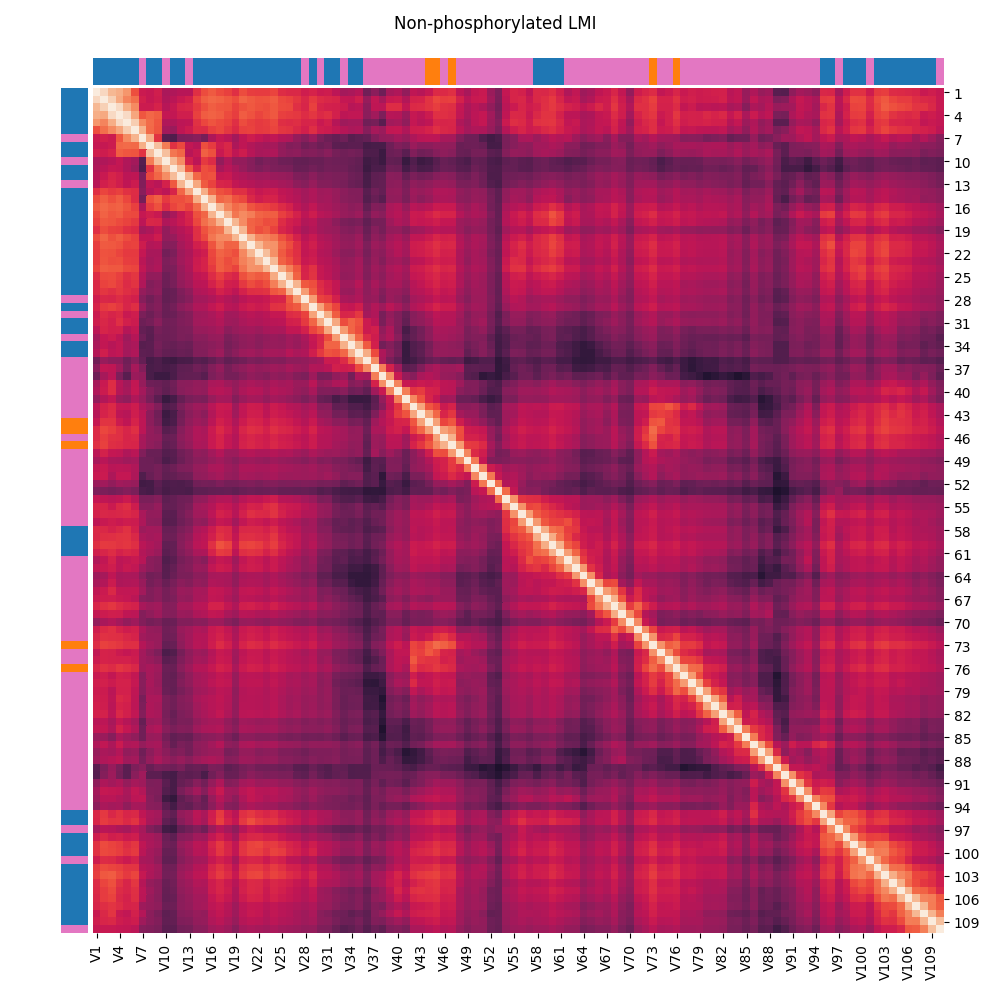

In [9]:
sns.clustermap(np_lmi,vmin=0,vmax=1,row_colors=np_row_colors,col_colors=np_row_colors,
               row_cluster=False, col_cluster=False, dendrogram_ratio=0.05, 
               cbar_pos=None)
plt.suptitle("Non-phosphorylated LMI")

In [ ]:
# Extract sequences
# MUSCLE alignment
# Get gap positions
# 